<a href="https://colab.research.google.com/github/davidcechak/DL-for-bio-course/blob/master/03_pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [4]:
# OPTIONAL
# Make kaggle account
# Profile -> Account -> Create new API token

# Runtime -> Change runtime type -> GPU -> Save
# Started code source: https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

In [5]:
# #UPLOAD KAGGLE JSON FILE
# from google.colab import files
# files.upload()

In [6]:
!echo '{"username":"wildauapi","key":"0120eef5b0949e46dc5fe54f5b2945c0"}' > kaggle.json

In [7]:
!pip install torchmetrics -q
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qq chest-xray-pneumonia.zip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.0 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:25<00:00, 89.4MB/s]
100% 2.29G/2.29G [00:25<00:00, 97.7MB/s]


## Data loading and exploration

In [8]:
import os
TRAIN_DATA_PATH = './chest_xray/train'
class_names = os.listdir(TRAIN_DATA_PATH)
class_names

['NORMAL', 'PNEUMONIA']

In [9]:
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(TRAIN_DATA_PATH,i)))

print(image_count)

{'NORMAL': 1341, 'PNEUMONIA': 3875}


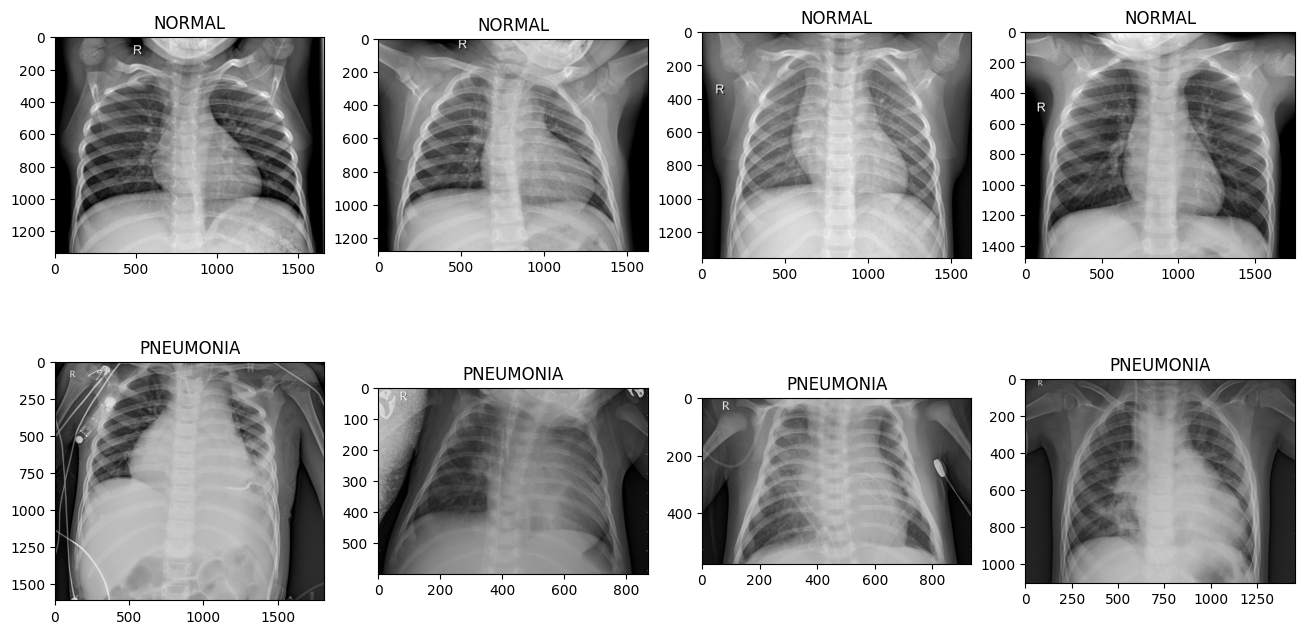

In [10]:
from random import shuffle
from matplotlib import pyplot as plt
import cv2
fig, axs = plt.subplots(2,4, figsize=(16,8))

for i,class_name in enumerate(class_names):
  img_paths = os.listdir(f'{TRAIN_DATA_PATH}/{class_name}')
  shuffle(img_paths)

  for j,image in enumerate(img_paths[:4]):
      img = cv2.imread(os.path.join(f'{TRAIN_DATA_PATH}/{class_name}', image))
      axs[i][j].title.set_text(class_name)
      axs[i][j].imshow(img)

fig.show()

In [11]:
normal_images_path = f'{TRAIN_DATA_PATH}/NORMAL'
img_file = os.listdir(normal_images_path)[0]
img_path = os.path.join(normal_images_path, img_file)
sample_X = cv2.imread(img_path)
print(sample_X)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [12]:
import numpy as np
print('Shape:',sample_X.shape)
print('Std:', np.std(sample_X))
print('Mean:', np.mean(sample_X))
print('Max:', np.max(sample_X))
print('Min:', np.min(sample_X))

Shape: (1086, 1562, 3)
Std: 67.92871750222184
Mean: 102.71612809284974
Max: 255
Min: 0


In [13]:
from torchvision import datasets, models, transforms

data_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(degrees = (-20,+20)),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),  #automaticcly crops to 0-1
])

In [14]:
train_data = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transforms)

In [15]:
train_data.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

torch.Size([3, 224, 224])
tensor(0.9765)
tensor(0.)


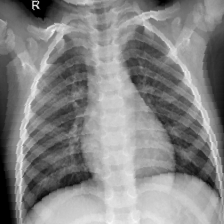

In [16]:
import numpy as np
from PIL import Image
import torch
image_tensor = train_data.__getitem__(10)[0]
print(image_tensor.size())
print(torch.max(image_tensor))
print(torch.min(image_tensor))

to_image_func = transforms.ToPILImage()
to_image_func(image_tensor)

In [17]:
import torch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

## Models

### MLP

In [18]:
import torch.nn as nn
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.softmax = nn.Softmax(dim=-1)


  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.softmax(out)
    return out

### CNN

In [28]:
import torch.nn as nn
import math

# let the code tell you the last conv layer's output shape
class CNN(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
        )
        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        # self.fc1 = nn.Linear(#TODO find out ???, 128)
        # self.relu3 = nn.ReLU()
        # self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.conv_layers(x)
        print(x.shape)  # See the shape, then hardcode it
        print("The output shape of the last conv layer will be the (product of) channels x with x height = {} which is {}".format(
            x.shape[1:],
            math.prod(x.shape[1:])
            )
        )
        pass

# CNN test
model = CNN(num_classes=2)
model(torch.rand(1, 3, 224, 224))

torch.Size([1, 64, 14, 14])
The output shape of the last conv layer will be the (product of) channels x with x height = torch.Size([64, 14, 14]) which is 12544


In [29]:
# class CNN(nn.Module):
#     def __init__(self,num_classes=2):
#         super().__init__()
#         # First convolutional block
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

#         # Second convolutional block
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)

#         # Flatten layer
#         self.flatten = nn.Flatten()

#         # Fully connected layers
#         # After conv and pooling: 224 -> 56 -> 14, so 64 * 14 * 14 = 12,544
#         self.fc1 = nn.Linear(64 * 14 * 14, 128)
#         self.relu3 = nn.ReLU()
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, input):
#         # First conv block
#         out = self.conv1(input)
#         out = self.relu1(out)
#         out = self.pool1(out)

#         # Second conv block
#         out = self.conv2(out)
#         out = self.relu2(out)
#         out = self.pool2(out)

#         # Flatten and fully connected layers
#         out = self.flatten(out)
#         out = self.fc1(out)
#         out = self.relu3(out)
#         out = self.fc2(out)

#         return out

# # CNN test
# model = CNN(num_classes=2)
# model(torch.rand(1, 3, 224, 224))

In [32]:
# use LazyLinear to infer input size automatically

class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(4, 4)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(4, 4)

        self.flatten = nn.Flatten()

        # LazyLinear will figure out input size automatically on first forward pass!
        self.fc1 = nn.LazyLinear(128)  # Don't need to specify input size!
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        out = self.conv1(input)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out


In [33]:
# CNN test
model = CNN(num_classes=2)
model(torch.rand(1, 3, 224, 224))

tensor([[0.5142, 0.4858]], grad_fn=<SoftmaxBackward0>)

### Pretrained

In [34]:
class MobileNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = models.mobilenet_v3_small(pretrained=True)
    last_layer_input_features = self.model.classifier[0].in_features
    # Optional freezing
    for param in model.parameters():
      param.requires_grad = False

    self.model.classifier = nn.Linear(last_layer_input_features, num_classes)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self,x):
    out = self.model(x)
    out = self.softmax(out)
    return out


## Model instance

In [35]:
# model = MLP(3*224*224, hidden_size=100, num_classes=2)
# model(torch.rand(32, 3*224*224)).size()

torch.Size([32, 2])

In [39]:
model = CNN(num_classes=2)
model(torch.rand(32, 3, 224, 224)).size()

torch.Size([32, 2])

In [37]:
# model = MobileNet(num_classes=2)
# model(torch.rand(32, 3, 224, 224)).size()

In [40]:
print('number of parameters')
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

number of parameters
1659714


## Balancing

In [46]:
# Calculate balanced weights
total_samples = sum(image_count.values())
n_classes = len(image_count)

# Create weight tensor matching class indices
class_weights = torch.zeros(n_classes)
for class_name, class_idx in train_data.class_to_idx.items():
    class_weights[class_idx] = total_samples / (n_classes * image_count[class_name])

print(f"Class indices: {train_data.class_to_idx}")
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights.float().cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Class weights: tensor([1.9448, 0.6730])


## Training

In [47]:
# model = MLP(3*224*224, hidden_size=100, num_classes=2)

In [48]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [49]:
from torchmetrics import Accuracy

accuracy_function = Accuracy(task='multiclass', num_classes=2)

model.cuda()
accuracy_function.cuda()

num_epochs = 2

for epoch in range(num_epochs):
  for batch_idx, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to('cuda')
    # inputs = inputs.reshape(-1,3*224*224).to('cuda') #For MLP
    labels = labels.to('cuda')

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if (batch_idx) % 10 == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy: %.4f'
        %(epoch+1, num_epochs, batch_idx, len(train_loader.dataset)//inputs.size()[0], loss.item(), accuracy_function(outputs,labels)))



Epoch [1/2], Step [0/163], Loss: 0.6870, Accuracy: 0.4062
Epoch [1/2], Step [10/163], Loss: 0.6429, Accuracy: 0.4375
Epoch [1/2], Step [20/163], Loss: 0.6754, Accuracy: 0.5000
Epoch [1/2], Step [30/163], Loss: 0.6066, Accuracy: 0.5938
Epoch [1/2], Step [40/163], Loss: 0.5346, Accuracy: 0.8125
Epoch [1/2], Step [50/163], Loss: 0.5144, Accuracy: 0.7500
Epoch [1/2], Step [60/163], Loss: 0.4376, Accuracy: 0.9062
Epoch [1/2], Step [70/163], Loss: 0.4494, Accuracy: 0.9062
Epoch [1/2], Step [80/163], Loss: 0.4673, Accuracy: 0.8750
Epoch [1/2], Step [90/163], Loss: 0.4680, Accuracy: 0.7500
Epoch [1/2], Step [100/163], Loss: 0.5874, Accuracy: 0.8438
Epoch [1/2], Step [110/163], Loss: 0.4028, Accuracy: 0.8125
Epoch [1/2], Step [120/163], Loss: 0.3728, Accuracy: 0.9375
Epoch [1/2], Step [130/163], Loss: 0.4054, Accuracy: 0.8125
Epoch [1/2], Step [140/163], Loss: 0.5445, Accuracy: 0.6250
Epoch [1/2], Step [150/163], Loss: 0.5182, Accuracy: 0.7500
Epoch [1/2], Step [160/163], Loss: 0.4043, Accuracy

## Evaluation

In [52]:
from torchmetrics import ConfusionMatrix
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm import tqdm


def get_metrics(model, loader):
  accuracy_function = Accuracy(task='multiclass', num_classes=2)
  #confusion matrix metric
  cm_function = ConfusionMatrix(task="multiclass", num_classes=2)
  accuracy_function.cuda()
  cm_function.cuda()

  all_predictions = []
  all_labels = []

  model.eval()
  with torch.no_grad():
    for images,labels in tqdm(loader):
      images = images.cuda()
      # images = images.reshape(-1,3*224*224).to('cuda') #FOR MLP
      labels = labels.cuda()

      output = model(images)
      all_predictions.append(output)
      all_labels.append(labels)

  #torch.cat concats tensors along new dimension
  print('\nAccuracy:', accuracy_function(torch.cat(all_predictions), torch.cat(all_labels)).item())
  conf_matrix = cm_function(torch.cat(all_predictions), torch.cat(all_labels))
  cm_display  = metrics.ConfusionMatrixDisplay(
      confusion_matrix = conf_matrix.cpu().numpy(),
      display_labels = ['NORMAL', 'PNEUMONIA']
  )
  cm_display.plot()
  plt.show()

In [ ]:
get_metrics(model, train_loader)

 58%|█████▊    | 95/163 [00:48<00:33,  2.04it/s]

## Testing

In [ ]:
TEST_DATA_PATH = './chest_xray/test'
# dont use augmentations for test
test_data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
test_data = datasets.ImageFolder(TEST_DATA_PATH, transform=test_data_transforms)
print(test_data.class_to_idx)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

get_metrics(model, test_loader)